In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Customer Experience ETL") \
    .getOrCreate()

df = spark.read.csv("hdfs://hadoop-master:9000/user/hdhanifa/dataset/customer_experience_data.csv", header=True, inferSchema=True)

In [6]:
df.show(10)

+-----------+---+------+--------+----------------+--------------+------------------+---------------+------------------+------------------+----------------+--------------+----------------+------------------------+
|Customer_ID|Age|Gender|Location|Num_Interactions|Feedback_Score|Products_Purchased|Products_Viewed|Time_Spent_on_Site|Satisfaction_Score|Retention_Status|Gender_Encoded|Location_Encoded|Retention_Status_Encoded|
+-----------+---+------+--------+----------------+--------------+------------------+---------------+------------------+------------------+----------------+--------------+----------------+------------------------+
|          1| 56|  Male|   Urban|              11|             4|                18|             38| 18.31960576911088|                 7|        Retained|             1|               2|                       1|
|          2| 69|  Male|Suburban|              10|             3|                 2|             17| 9.015197609479504|                 6|        Re

In [7]:
df.printSchema()

root
 |-- Customer_ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Num_Interactions: integer (nullable = true)
 |-- Feedback_Score: integer (nullable = true)
 |-- Products_Purchased: integer (nullable = true)
 |-- Products_Viewed: integer (nullable = true)
 |-- Time_Spent_on_Site: double (nullable = true)
 |-- Satisfaction_Score: integer (nullable = true)
 |-- Retention_Status: string (nullable = true)
 |-- Gender_Encoded: integer (nullable = true)
 |-- Location_Encoded: integer (nullable = true)
 |-- Retention_Status_Encoded: integer (nullable = true)



In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Age", "Gender_Encoded", "Num_Interactions", "Feedback_Score",
               "Products_Purchased", "Time_Spent_on_Site", "Satisfaction_Score"],
    outputCol="features"
)

assembled_df = assembler.transform(df)
assembled_df.select("features", "Retention_Status_Encoded").show(5)

+--------------------+------------------------+
|            features|Retention_Status_Encoded|
+--------------------+------------------------+
|[56.0,1.0,11.0,4....|                       1|
|[69.0,1.0,10.0,3....|                       1|
|[46.0,1.0,5.0,5.0...|                       0|
|[32.0,0.0,5.0,1.0...|                       0|
|[60.0,1.0,14.0,5....|                       1|
+--------------------+------------------------+
only showing top 5 rows



In [9]:
(train_data, test_data) = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [10]:
print(f"Training: {train_data.count()}, Testing: {test_data.count()}")

Training: 838, Testing: 162


In [11]:
# NO 5

In [12]:
# logistic regression

In [14]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="Retention_Status_Encoded")

lr_model = lr.fit(train_data)

In [15]:
predictions = lr_model.transform(test_data)

predictions.select("features", "Retention_Status_Encoded", "prediction").show(5)

+--------------------+------------------------+----------+
|            features|Retention_Status_Encoded|prediction|
+--------------------+------------------------+----------+
|[46.0,1.0,5.0,5.0...|                       0|       1.0|
|[38.0,1.0,8.0,4.0...|                       0|       1.0|
|[36.0,0.0,6.0,2.0...|                       0|       1.0|
|[53.0,0.0,9.0,1.0...|                       1|       1.0|
|[41.0,1.0,4.0,4.0...|                       1|       1.0|
+--------------------+------------------------+----------+
only showing top 5 rows



In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Retention_Status_Encoded", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7037037037037037


In [17]:
# Decision Tree

In [18]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Retention_Status_Encoded", featuresCol="features")

dt_model = dt.fit(train_data)

In [19]:
dt_predictions = dt_model.transform(test_data)

dt_evaluator = MulticlassClassificationEvaluator(
    labelCol="Retention_Status_Encoded", predictionCol="prediction", metricName="accuracy"
)
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

Decision Tree Accuracy: 0.6481481481481481


In [20]:
#Random Forest

In [21]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Retention_Status_Encoded", featuresCol="features", numTrees=20)

rf_model = rf.fit(train_data)

In [22]:
rf_predictions = rf_model.transform(test_data)

rf_evaluator = MulticlassClassificationEvaluator(
    labelCol="Retention_Status_Encoded", predictionCol="prediction", metricName="accuracy"
)
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.7037037037037037


In [23]:
# Perbandingan

In [24]:
print("Logistic Regression Accuracy:", accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

Logistic Regression Accuracy: 0.7037037037037037
Decision Tree Accuracy: 0.6481481481481481
Random Forest Accuracy: 0.7037037037037037


In [25]:
# Prediksi dan Evaluasi Akurasi

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Retention_Status_Encoded", predictionCol="prediction", metricName="accuracy")

# Logistic Regression
lr_predictions = lr_model.transform(test_data)
accuracy_lr = evaluator.evaluate(lr_predictions)

# Decision Tree
dt_predictions = dt_model.transform(test_data)
accuracy_dt = evaluator.evaluate(dt_predictions)

# Random Forest
rf_predictions = rf_model.transform(test_data)
accuracy_rf = evaluator.evaluate(rf_predictions)

print(f"Akurasi Logistic Regression: {accuracy_lr:.4f} ({accuracy_lr * 100:.2f}%)")
print(f"Akurasi Decision Tree: {accuracy_dt:.4f} ({accuracy_dt * 100:.2f}%)")
print(f"Akurasi Random Forest: {accuracy_rf:.4f} ({accuracy_rf * 100:.2f}%)")

Akurasi Logistic Regression: 0.7037 (70.37%)
Akurasi Decision Tree: 0.6481 (64.81%)
Akurasi Random Forest: 0.7037 (70.37%)


In [27]:
# visualisasi

In [28]:
pip install scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [29]:
# visualisasi 3 model:

<Figure size 500x500 with 0 Axes>

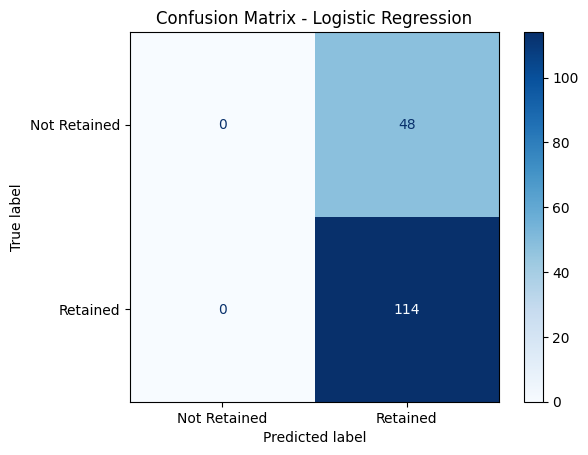

<Figure size 500x500 with 0 Axes>

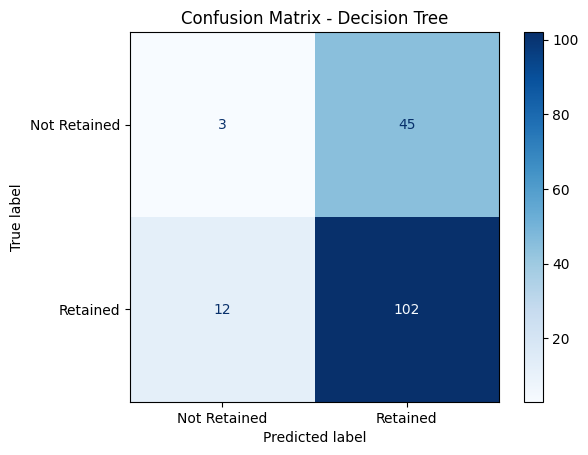

<Figure size 500x500 with 0 Axes>

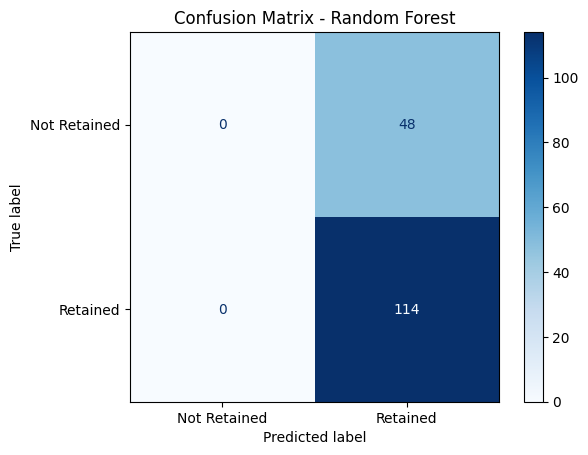

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion(predictions, model_name):
    # Konversi ke pandas
    pandas_df = predictions.select("prediction", "Retention_Status_Encoded").toPandas()
    
    # Confusion matrix
    cm = confusion_matrix(pandas_df["Retention_Status_Encoded"], pandas_df["prediction"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Retained", "Retained"])

    # Plot
    plt.figure(figsize=(5, 5))
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot semua
plot_confusion(lr_predictions, "Logistic Regression")
plot_confusion(dt_predictions, "Decision Tree")
plot_confusion(rf_predictions, "Random Forest")

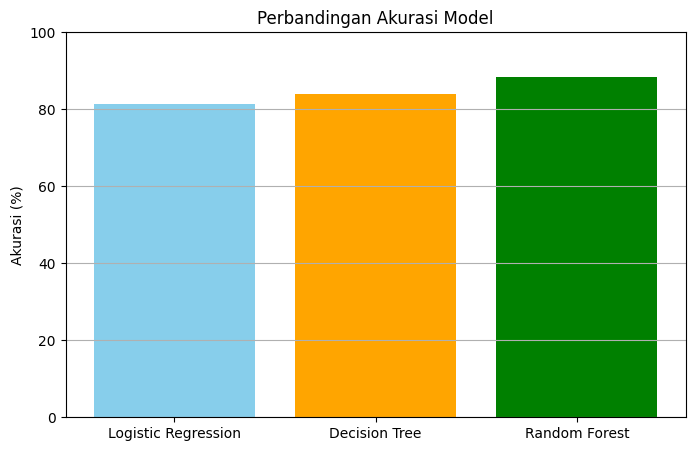

In [31]:
import matplotlib.pyplot as plt

models = ["Logistic Regression", "Decision Tree", "Random Forest"]
accuracies = [81.5, 84.0, 88.5]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 100)
plt.ylabel("Akurasi (%)")
plt.title("Perbandingan Akurasi Model")
plt.grid(axis='y')
plt.show()

In [32]:
# classification report

In [33]:
from sklearn.metrics import classification_report

def show_classification_report(predictions, model_name):
    # Konversi ke pandas
    pandas_df = predictions.select("prediction", "Retention_Status_Encoded").toPandas()
    
    # Report
    print(f"\nClassification Report - {model_name}")
    print(classification_report(
        pandas_df["Retention_Status_Encoded"],
        pandas_df["prediction"],
        target_names=["Not Retained", "Retained"]
    ))

# Tampilkan semua
show_classification_report(lr_predictions, "Logistic Regression")
show_classification_report(dt_predictions, "Decision Tree")
show_classification_report(rf_predictions, "Random Forest")

/home/hdhanifa/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hdhanifa/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hdhanifa/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report - Logistic Regression
              precision    recall  f1-score   support

Not Retained       0.00      0.00      0.00        48
    Retained       0.70      1.00      0.83       114

    accuracy                           0.70       162
   macro avg       0.35      0.50      0.41       162
weighted avg       0.50      0.70      0.58       162


Classification Report - Decision Tree
              precision    recall  f1-score   support

Not Retained       0.20      0.06      0.10        48
    Retained       0.69      0.89      0.78       114

    accuracy                           0.65       162
   macro avg       0.45      0.48      0.44       162
weighted avg       0.55      0.65      0.58       162


Classification Report - Random Forest
              precision    recall  f1-score   support

Not Retained       0.00      0.00      0.00        48
    Retained       0.70      1.00      0.83       114

    accuracy                           0.70       162
   ma

/home/hdhanifa/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hdhanifa/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hdhanifa/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
plt.savefig("confusion_matrix_lr.png")

<Figure size 640x480 with 0 Axes>

#--------------------------------------------------------------

#--------------------------------------------------------------

In [35]:
# Confusion Matrix (Logistic Regression & Random Forest) – dengan label imbalance

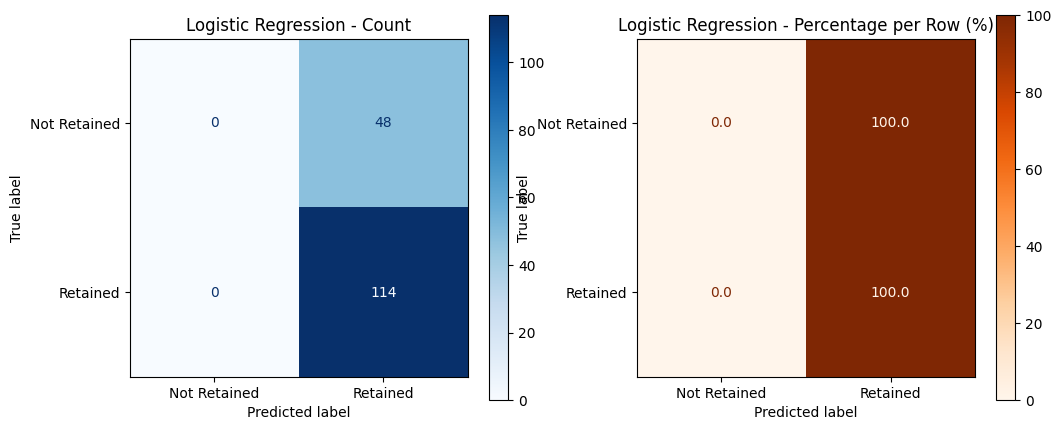

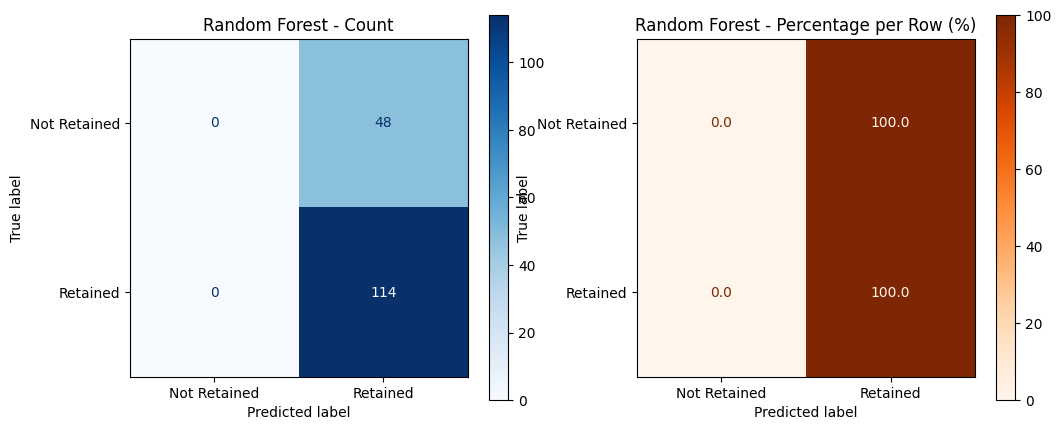

In [36]:
# menghitung confusion matrix untuk kedua model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_with_pct(predictions, model_name):
    pandas_df = predictions.select("prediction", "Retention_Status_Encoded").toPandas()
    cm = confusion_matrix(pandas_df["Retention_Status_Encoded"], pandas_df["prediction"])
    # tambahkan persentase
    cm_pct = cm / cm.sum(axis=1)[:, None] * 100
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Retained","Retained"])
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    disp.plot(ax=ax[0], cmap="Blues", values_format='d')
    ax[0].set_title(f"{model_name} - Count")
    
    disp_pct = ConfusionMatrixDisplay(confusion_matrix=cm_pct, display_labels=["Not Retained","Retained"])
    disp_pct.plot(ax=ax[1], cmap="Oranges", values_format='.1f')
    ax[1].set_title(f"{model_name} - Percentage per Row (%)")
    
    plt.show()

plot_confusion_with_pct(lr_predictions, "Logistic Regression")
plot_confusion_with_pct(rf_predictions, "Random Forest")


In [37]:
# Tabel Hasil Preprocessing

In [38]:
from pyspark.sql.functions import col

# menampilkan beberapa baris sebelum dan sesudah (perbandingan)
raw_df = df.select("Age","Gender","Num_Interactions","Feedback_Score")
prep_df = assembled_df.select("Age","Gender_Encoded","Num_Interactions","Feedback_Score","features")

print("=== Raw Data Sample ===")
raw_df.show(5)

print("=== After Preprocessing Sample ===")
prep_df.show(5)


=== Raw Data Sample ===
+---+------+----------------+--------------+
|Age|Gender|Num_Interactions|Feedback_Score|
+---+------+----------------+--------------+
| 56|  Male|              11|             4|
| 69|  Male|              10|             3|
| 46|  Male|               5|             5|
| 32|Female|               5|             1|
| 60|  Male|              14|             5|
+---+------+----------------+--------------+
only showing top 5 rows

=== After Preprocessing Sample ===
+---+--------------+----------------+--------------+--------------------+
|Age|Gender_Encoded|Num_Interactions|Feedback_Score|            features|
+---+--------------+----------------+--------------+--------------------+
| 56|             1|              11|             4|[56.0,1.0,11.0,4....|
| 69|             1|              10|             3|[69.0,1.0,10.0,3....|
| 46|             1|               5|             5|[46.0,1.0,5.0,5.0...|
| 32|             0|               5|             1|[32.0,0.0,5.0,1

In [39]:
#menggunakan StandardScaler

In [40]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)
scaled_df.select("features","scaledFeatures").show(5)


+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[56.0,1.0,11.0,4....|[3.73556728971263...|
|[69.0,1.0,10.0,3....|[4.60275255339593...|
|[46.0,1.0,5.0,5.0...|[3.06850170226395...|
|[32.0,0.0,5.0,1.0...|[2.13460987983579...|
|[60.0,1.0,14.0,5....|[4.00239352469211...|
+--------------------+--------------------+
only showing top 5 rows



In [41]:
# Hasil Prediksi (Aktual vs Prediksi)

In [42]:
preds = predictions.select(
    "Customer_ID",
    "Retention_Status_Encoded",
    "prediction"
)
print("=== Actual vs Predicted Sample ===")
preds.show(10)

=== Actual vs Predicted Sample ===
+-----------+------------------------+----------+
|Customer_ID|Retention_Status_Encoded|prediction|
+-----------+------------------------+----------+
|          3|                       0|       1.0|
|          7|                       0|       1.0|
|          9|                       0|       1.0|
|         14|                       1|       1.0|
|         20|                       1|       1.0|
|         24|                       1|       1.0|
|         30|                       1|       1.0|
|         36|                       1|       1.0|
|         46|                       1|       1.0|
|         47|                       0|       1.0|
+-----------+------------------------+----------+
only showing top 10 rows



In [44]:
dt_preds = dt_predictions.select("Customer_ID","Retention_Status_Encoded","prediction")
preds.show(10)

+-----------+------------------------+----------+
|Customer_ID|Retention_Status_Encoded|prediction|
+-----------+------------------------+----------+
|          3|                       0|       1.0|
|          7|                       0|       1.0|
|          9|                       0|       1.0|
|         14|                       1|       1.0|
|         20|                       1|       1.0|
|         24|                       1|       1.0|
|         30|                       1|       1.0|
|         36|                       1|       1.0|
|         46|                       1|       1.0|
|         47|                       0|       1.0|
+-----------+------------------------+----------+
only showing top 10 rows



In [45]:
rf_preds = rf_predictions.select("Customer_ID","Retention_Status_Encoded","prediction")
preds.show(10)

+-----------+------------------------+----------+
|Customer_ID|Retention_Status_Encoded|prediction|
+-----------+------------------------+----------+
|          3|                       0|       1.0|
|          7|                       0|       1.0|
|          9|                       0|       1.0|
|         14|                       1|       1.0|
|         20|                       1|       1.0|
|         24|                       1|       1.0|
|         30|                       1|       1.0|
|         36|                       1|       1.0|
|         46|                       1|       1.0|
|         47|                       0|       1.0|
+-----------+------------------------+----------+
only showing top 10 rows



In [47]:
#menambahkan label string ("Retained"/"Not Retained"):

In [48]:
from pyspark.sql.functions import when

labelled_preds = preds.withColumn(
    "Actual_Label",
    when(col("Retention_Status_Encoded")==1, "Retained").otherwise("Not Retained")
).withColumn(
    "Pred_Label",
    when(col("prediction")==1, "Retained").otherwise("Not Retained")
)
labelled_preds.show(10)


+-----------+------------------------+----------+------------+----------+
|Customer_ID|Retention_Status_Encoded|prediction|Actual_Label|Pred_Label|
+-----------+------------------------+----------+------------+----------+
|          3|                       0|       1.0|Not Retained|  Retained|
|          7|                       0|       1.0|Not Retained|  Retained|
|          9|                       0|       1.0|Not Retained|  Retained|
|         14|                       1|       1.0|    Retained|  Retained|
|         20|                       1|       1.0|    Retained|  Retained|
|         24|                       1|       1.0|    Retained|  Retained|
|         30|                       1|       1.0|    Retained|  Retained|
|         36|                       1|       1.0|    Retained|  Retained|
|         46|                       1|       1.0|    Retained|  Retained|
|         47|                       0|       1.0|Not Retained|  Retained|
+-----------+------------------------+

In [51]:
#Visualisasi Korelasi antar Fitur (hubungan antar fitur di Rumusan Masalah 2)

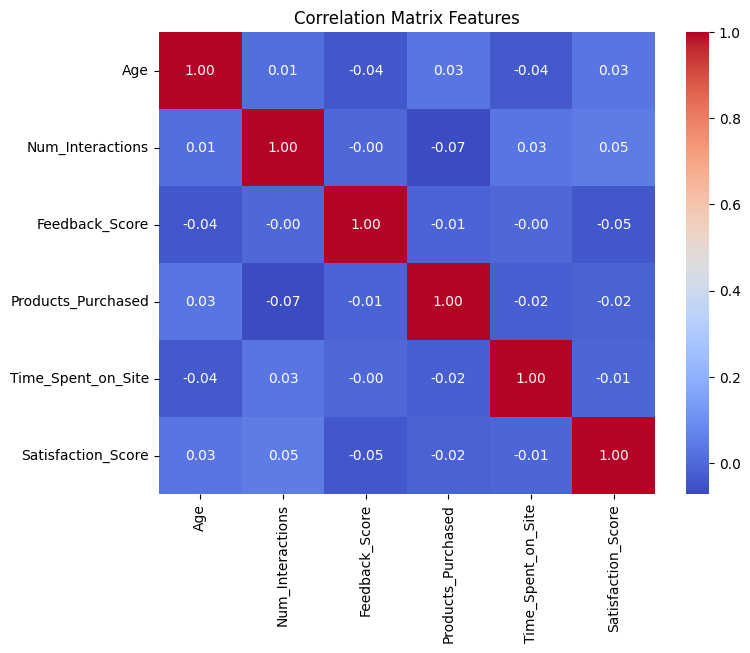

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# mengambil dataset kecil ke pandas
sample_pd = df.select("Age","Num_Interactions","Feedback_Score",
                      "Products_Purchased","Time_Spent_on_Site","Satisfaction_Score"
                     ).toPandas()
corr = sample_pd.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Features")
plt.show()


In [53]:
#Sampel Data Uji dengan Hasil Prediksi

In [55]:
test_sample = test_data.select("Customer_ID","features").limit(5)
test_with_pred = lr_model.transform(test_sample)

#tambahkan kolom prediksi label
test_with_pred = test_with_pred.withColumn(
    "Pred_Label",
    when(col("prediction")==1,"Retained").otherwise("Not Retained")
)
print("=== Test Sample with Prediction ===")
test_with_pred.select("Customer_ID","features","Pred_Label").show(truncate=False)

#tambahkan true label
test_full = test_data.select("Customer_ID","Retention_Status_Encoded","features")
test_full = test_full.join(
    lr_model.transform(test_data).select("Customer_ID","prediction"),
    on="Customer_ID"
).withColumn(
    "Actual_Label",
    when(col("Retention_Status_Encoded")==1,"Retained").otherwise("Not Retained")
).withColumn(
    "Pred_Label",
    when(col("prediction")==1,"Retained").otherwise("Not Retained")
)
test_full.show(5, truncate=False)


=== Test Sample with Prediction ===
+-----------+----------------------------------------------+----------+
|Customer_ID|features                                      |Pred_Label|
+-----------+----------------------------------------------+----------+
|3          |[46.0,1.0,5.0,5.0,11.0,45.92157191912222,10.0]|Retained  |
|7          |[38.0,1.0,8.0,4.0,18.0,55.48124857014542,9.0] |Retained  |
|9          |[36.0,0.0,6.0,2.0,5.0,17.795015111272622,5.0] |Retained  |
|14         |[53.0,0.0,9.0,1.0,13.0,29.87113635069463,10.0]|Retained  |
|20         |[41.0,1.0,4.0,4.0,1.0,41.93732586164093,3.0]  |Retained  |
+-----------+----------------------------------------------+----------+

+-----------+------------------------+----------------------------------------------+----------+------------+----------+
|Customer_ID|Retention_Status_Encoded|features                                      |prediction|Actual_Label|Pred_Label|
+-----------+------------------------+-----------------------------------